# **STOMPX**
## Stochastic propagations on networks with application to malware
[GitHub_repository](https://github.com/rrodgar/stompx)

In [1]:
import networkx as nx
import stompx as sx

## **A Quick-Example**
 A small network is created with networkx and a SIR model type is propagated over the network

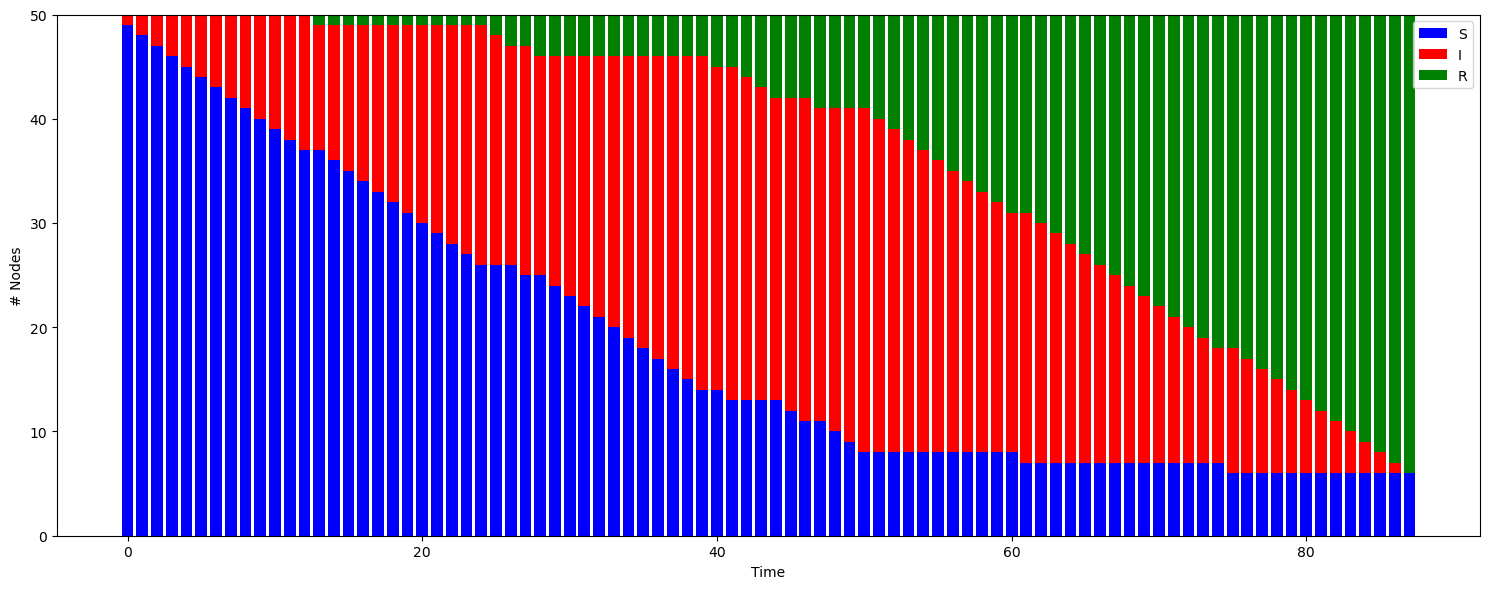

In [2]:
G = nx.powerlaw_cluster_graph(50, m = 3, p = 0.4 , seed = 42)

model1 = sx.Gillespie_SIR_Network(
    G = G,
    beta = 0.4,
    gamma= 0.3,
    num_initial_infected=1
)
model1.run_simulation(tmax=30)
sx.plot_bars(model1)

An interactive animation can be created using the library

In [3]:
sx.plot_animation(network=G,model=model1)

In [4]:
sx.statistics_summary(model=model1)


Outbreak statistics summary
-----------------------------------
Number of simulations      : 100
Mean I_max                 : 24.79 ± 11.33
Extinction probability     : 0.150
Mean extinction time       : 11.78
-----------------------------------


## **Creating a new model**
One of the main goals of **TOMPX** is not to provide a fixed collection of
epidemiological models, but a **flexible framework** for implementing and
experimenting with stochastic spreading dynamics on networks.
To illustrate this idea, we consider a **minimal discrete-time SEIR model**
implemented via **inheritance**, using a Monte Carlo update scheme.
This example is intentionally simple and should be interpreted as a *toy model*.

SEIR dynamics can be modeled:
$$
S \rightarrow E \rightarrow I \rightarrow R 
$$
where:
- **S (Susceptible)**: healthy and vulnerable to infection,
- **E (Exposed)**: infected but not yet infectious (incubation),
- **I (Infected)**: actively spreading the infection,
- **R (Recovered)**: recovered from infection.

The transitions follow a simple probabilistic rule set:

- **S → E**: occurs with a probability that depends on the number of infected
  neighbors,
- **E → I**: occurs with a fixed probability σ,
- **I → R**: occurs with a fixed recovery probability γ.

This new model can be created overriding a small number of method, without modyfing the core library.

In [5]:
from stompx.models import Montecarlo_SIR_Network
import numpy as np
class MonteCarlo_SEIR_Toymodel(Montecarlo_SIR_Network):
    def __init__(self, G, gamma, num_initial_infected, beta, sigma,initial_inf_method='aleatorio'):
         self.G = G
         self.gamma = gamma
         self.num_initial_infected = num_initial_infected
         self.initial_inf_method = initial_inf_method
         self.beta = beta
         self.sigma = sigma
    def new_state(self, node, states_old):
        state = states_old[node]
        r = np.random.rand()
        if state == "S":
                inf_neighbors = [i for i in self.G.neighbors(node) if states_old[i]=='I']
                l_inf_neighbors = len(inf_neighbors)

                if r < (1 - (1 - self.beta) ** l_inf_neighbors):
                    return 'E'

        elif state == "E":
                if r < self.sigma:
                    return 'I'

        elif state == "I":
                if r < self.gamma:
                    return  "R"
        return state
    

### State–color mapping for visualization

To visualize the network dynamics, a **state–color dictionary** must be provided,
where each key corresponds to a node state and each value specifies the color
used in the plots.

For example, in the SEIR toy model, a suitable mapping is:

```python
state_colors = {
    "S": "blue",
    "E": "orange",
    "I": "red",
    "R": "green",
}
```
If no state_colors dictionary is provided, the plotting utilities fall back
to a default SIR color mapping:
```python
state_colors= {"S": "blue", "I": "red", "R": "green"}
```

In [6]:
toymodel = MonteCarlo_SEIR_Toymodel(G=G, gamma=0.1,beta=0.15, sigma=0.25,num_initial_infected=1)
toymodel.run_simulation(steps=50)
state_colors = {
    'S': 'blue',
    'E': 'orange',
    'I': 'red',
    'R': 'green'
}

sx.plot_animation(network=G,model = toymodel,state_colors=state_colors)


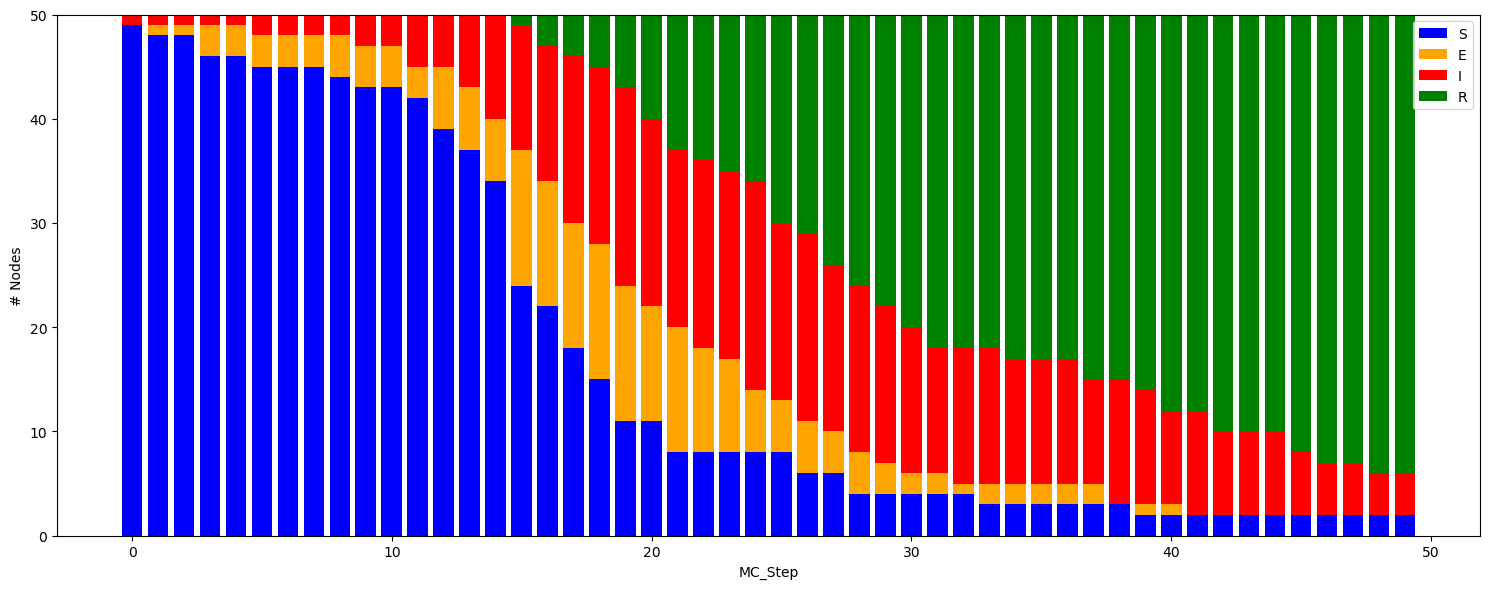

In [7]:
sx.plot_bars(toymodel, state_colors=state_colors, gillespie=False)

## **A case of study**
To illustrate how **stompx** can be used in practice for research-oriented
analysis, we consider a simple case studying a model incorporating **topological overlap (TOM)** into the infection dynamics ([1]).

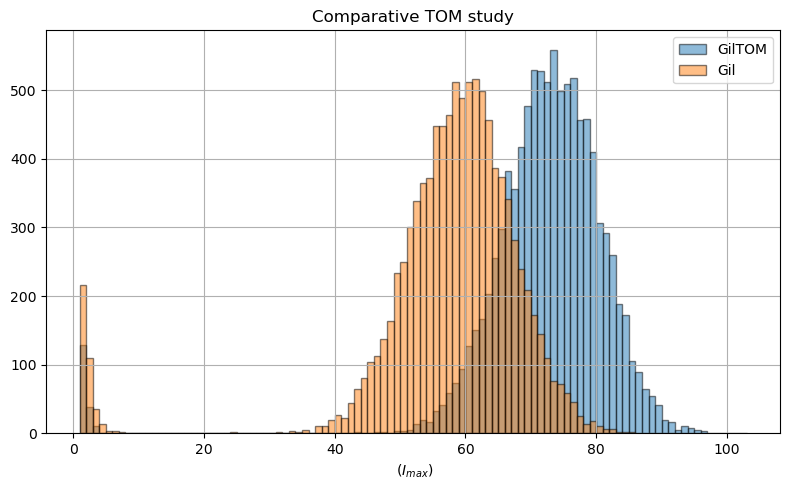

In [9]:
# Create a network
G2 = nx.powerlaw_cluster_graph(128,3,0.4,seed=42)
TOM_model = sx.Gillespie_SIR_Network_TOM(G= G2,beta=0.2, gamma=0.2, num_initial_infected=1, initial_inf_method='degree')
simple_model = sx.Gillespie_SIR_Network(G = G2, beta=0.2 , gamma=0.2, num_initial_infected=1, initial_inf_method='degree')

sx.plot_Imax_comparative(
    models=[TOM_model, simple_model],
    tags= ["GilTOM", "Gil"],
    n_sim=10000,
    tmax=15,
    title='Comparative TOM study'
)



we compare mean infection curves obtained for different values of the recovery rate \( \gamma \), both for a baseline SIR model and for its TOM-weighted variant. The curves are generated by averaging multiple Gillespie realizations.
This illustrates how the user can work with the library and custom functions.

<function matplotlib.pyplot.show(close=None, block=None)>

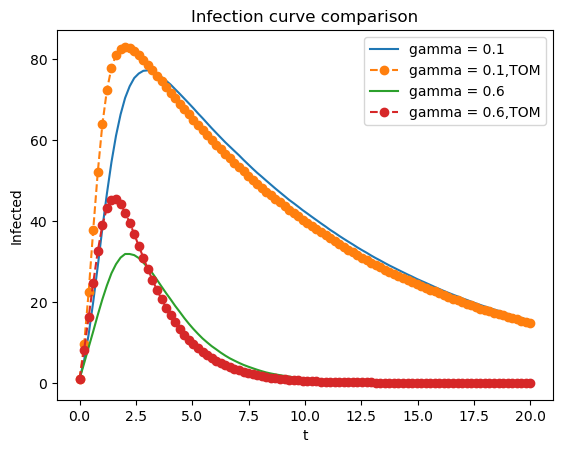

In [13]:

import matplotlib.pyplot as plt
N = 100
G_pw = nx.powerlaw_cluster_graph(N,3,0.4,seed=42)

gammas = [0.1,0.6]
for gamma in gammas:
    sim_TOM = sx.Gillespie_SIR_Network(G_pw, beta=0.5, gamma=gamma, num_initial_infected=1, initial_inf_method='degree')
    sim_normal = sx.Gillespie_SIR_Network_TOM(G_pw,beta=0.5, gamma=gamma, num_initial_infected=1, initial_inf_method='degree')

    t_uni, I_prom, I_std = sx.mean_infected_gillespie(sim_TOM, n_sim=1000, t_max=20)
    t_uni2, I_prom2, I_std2 = sx.mean_infected_gillespie(sim_normal, n_sim=1000, t_max=20)

    plt.plot(t_uni, I_prom, label = f"gamma = {gamma}")
    plt.plot(t_uni2, I_prom2, '--o',label = f"gamma = {gamma},TOM")

plt.xlabel("t")
plt.ylabel("Infected")
plt.title(f"Infection curve comparison")
plt.legend()
plt.grid(False)
plt.show

## **References**
1.  R. Rodríguez-García and A. Herrero,"Local Structure Information to Enhance Modeling of Malware in IoT Networks". IEEE access. ***Under Review***